In [1]:
import tiktoken
import chardet
import json
import torch
from dotenv import load_dotenv
import numpy as np
import spacy
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
load_dotenv()

True

In [2]:
import base64
import requests
vocab = []
with open(r"DataManipulation\cl100k_base.tiktoken", 'rb') as f:
    contents = f.read()
# res = requests.get('https://openaipublic.blob.core.windows.net/encodings/cl100k_base.tiktoken')
# contents = res.content

for token, rank in (line.split() for line in contents.splitlines() if line):
    decoded_token = base64.b64decode(token)

    try:
        t = repr(decoded_token.decode('utf-8'))
    except:
        t = decoded_token
    finally:
        t = t[1:-1] if type(t)==str else t.decode('unicode_escape')
        vocab.append(t)
vocab = list(set(vocab))

In [3]:
vocab

['ishment',
 '(tensor',
 ' Alv',
 'alles',
 ' Cait',
 ' magician',
 ' kilometres',
 '843',
 ' argc',
 'attempt',
 ' reife',
 'ropped',
 '/////////////////////////////////////////////////////////////////////////////\\n',
 ' tiener',
 'vider',
 ' listening',
 '_pm',
 ' towing',
 'Around',
 'PDOException',
 ' flipped',
 ' Jonas',
 'NR',
 '__);\\n',
 ' poetic',
 'nb',
 'ョ',
 'Vectors',
 ' Shotgun',
 ' XCTestCase',
 '_control',
 '~":"',
 ' Skinner',
 '<X',
 'CEF',
 ' POT',
 'axed',
 'errick',
 ' THEM',
 '_permission',
 'iplina',
 ' sweetheart',
 'sti',
 ' debate',
 '(QString',
 ' prophet',
 '(rowIndex',
 'urret',
 '$route',
 ' Trans',
 ' translation',
 ' professionally',
 ' Setter',
 '.IN',
 ' asset',
 'ográf',
 'provided',
 ' Tal',
 '.gs',
 ' credited',
 'Pok',
 '.Serve',
 ' decipher',
 '.Maybe',
 ' exp',
 ' tut',
 ' tablesp',
 ' transferring',
 'pagesize',
 '\x92á\x9e',
 'Attendance',
 'Spoiler',
 ' semantics',
 'Unity',
 ' injection',
 ' ventana',
 'veget',
 '除',
 ':".',
 'coll',
 ' zero

In [8]:
import tiktoken

def get_tiktoken_vocab():
    # Load TikToken encoding
    encoding = tiktoken.get_encoding("cl100k_base")
    
    # Retrieve all tokens and their integer IDs
    token_to_id = encoding._mergeable_ranks
    
    # Convert tokens to UTF-8 strings
    id_to_token_utf8 = {token_id: token.decode("utf-8", errors="replace") 
                        for token, token_id in token_to_id.items()}
    
    return id_to_token_utf8

In [9]:
vobabs = get_tiktoken_vocab()

In [10]:
vobabs[1520]

' help'

In [11]:
import tiktoken

# Load the cl100k_base encoding
encoding = tiktoken.get_encoding("cl100k_base")

# Reverse the vocabulary to map IDs to tokens
id_to_token = {v: k for k, v in encoding._mergeable_ranks.items()}

# Get the raw token bytes at index 80242
raw_token = id_to_token.get(80242, None)

if raw_token is not None:
    print(f"Raw token at index 80242: {raw_token}")
else:
    print("Token at index 80242 not found.")


Raw token at index 80242: b'\xe7\x8f'


In [7]:
print(len(encoding._mergeable_ranks))
print(len(id_to_token))

100256
100256


In [8]:
len(vocab)

100164

In [10]:
tt = b'\x81'
tt.decode('utf8', errors='replace')

'�'

In [69]:
line_count = 0
max_lines_per_file = 40000
file_index = 1

output_file = rf"DataManipulation\\embedding_requests_part{file_index}.jsonl"
file = open(output_file, "w", encoding="utf-8")

for k, v in id_to_token.items():
    encoding = chardet.detect(v)["encoding"]
    t = v.decode(encoding, errors='ignore') if encoding!=None else v
    template = {
        "custom_id": str(k),
        "method": "POST",
        "url": "/v1/embeddings",
        "body": {
            "model": "text-embedding-3-large",
            "input": f'{t}',
            "encoding_format": "float"
        }
    }
    # Write the JSON object as a line in the JSONL file
    file.write(json.dumps(template) + "\n")
    line_count += 1
    if line_count >= max_lines_per_file:
        file.close()
        file_index += 1
        line_count = 0
        output_file = rf"DataManipulation\\embedding_requests_part{file_index}.jsonl"
        file = open(output_file, "w", encoding="utf-8")

file.close()

In [11]:
GPTEmbeddingPaths = [
    r"DataManipulation\p1_batch_6737dca63e148190af3203b4ecae25cc_output.jsonl",
    r"DataManipulation\p2_batch_6737dcc29c2c8190a6a2cb151a561291_output.jsonl",
    r"DataManipulation\p3_batch_6737dcd9968c8190901e2bcaced7aad4_output.jsonl"
]

In [15]:
data_embeddings = {}
for emb_path in GPTEmbeddingPaths:
    with open(emb_path, 'rt') as f:
        all_lines = []
        line_stream = f.readlines()
        for line in line_stream:
            all_lines.append(json.loads(line))
        for line_data in all_lines:
            data_embeddings[int(line_data['custom_id'])] = torch.tensor(line_data['response']['body']['data'][0]['embedding'])

In [16]:
len(data_embeddings)

100256

In [84]:
embeddings = []
for i in range(len(data_embeddings)):
    embeddings.append(data_embeddings[i])
embeddings = torch.vstack(embeddings)
embeddings.shape

In [140]:
%%time
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

reducer = UMAP(n_neighbors=15, n_components=64, min_dist=0.1, metric='euclidean', random_state=42, verbose=True)
embeddings64 = reducer.fit_transform(embeddings_scaled)
embeddings64.shape

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_components=64, random_state=42, verbose=True)
Mon Nov 18 09:56:14 2024 Construct fuzzy simplicial set
Mon Nov 18 09:56:16 2024 Finding Nearest Neighbors
Mon Nov 18 09:56:16 2024 Building RP forest with 21 trees
Mon Nov 18 09:57:11 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Mon Nov 18 09:57:39 2024 Finished Nearest Neighbor Search
Mon Nov 18 09:57:46 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 18 10:07:43 2024 Finished embedding
CPU times: total: 25min 11s
Wall time: 14min 44s


(100256, 64)

In [141]:
with open(r'data\ReducedEmbeddings\gpt_large_reduced_embeddings_64.npy', 'wb') as f:
    np.save(f, embeddings64, False)

In [118]:
%%time
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

reducer = UMAP(n_neighbors=15, n_components=128, min_dist=0.1, metric='euclidean', random_state=42, verbose=True)
embeddings128 = reducer.fit_transform(embeddings_scaled)
embeddings128.shape

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_components=128, random_state=42, verbose=True)
Mon Nov 18 04:11:50 2024 Construct fuzzy simplicial set
Mon Nov 18 04:11:54 2024 Finding Nearest Neighbors
Mon Nov 18 04:11:55 2024 Building RP forest with 21 trees
Mon Nov 18 04:13:08 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Mon Nov 18 04:14:05 2024 Finished Nearest Neighbor Search
Mon Nov 18 04:14:24 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 18 04:47:41 2024 Finished embedding
CPU times: total: 54min 16s
Wall time: 38min 3s


(100256, 128)

In [120]:
with open(r'data\ReducedEmbeddings\gpt_large_reduced_embeddings_128.npy', 'wb') as f:
    np.save(f, embeddings128, False)

In [21]:
encoding._mergeable_ranks[b'good']

19045

In [121]:
extra_tokens = {
    'g': ['good', 'bad', 'nice', 'evil', 'pleasant', 'awesome', 'love', 'fair'],
    'b': ['king', 'queen', 'lord', 'master', 'maid', 'leader', 'chief'],
    'y': ['car', 'traffic', 'wheel', 'bus', 'train', 'truck', 'bike', 'lane', 'road'],
    'r': ['sport', 'ball', 'match', 'competition', 'player', 'football', 'game', 'play']
}

target_tokens = []
color_codes = []
for color, tokens in extra_tokens.items():
    for token in tokens:
        target_tokens.append(token)
        color_codes.append(color)

idx = [encoding._mergeable_ranks[str.encode(t)] for t in target_tokens]

In [122]:
all_vocab = [vobabs[i] for i in range(len(vobabs))]

In [123]:
encoding._mergeable_ranks[b'maid']

46342

In [124]:
embeddings[idx]
embeddings64[idx]
embeddings128[idx]
target_vocab = [all_vocab[i] for i in idx]

In [142]:
tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=1, n_iter=300, metric='euclidean')

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


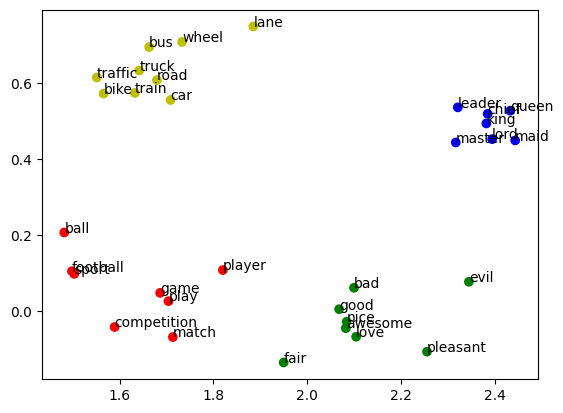

In [143]:
X_tsne = tsne.fit_transform(embeddings[idx])
df = pd.DataFrame(X_tsne, index=target_vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'], c=color_codes)
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


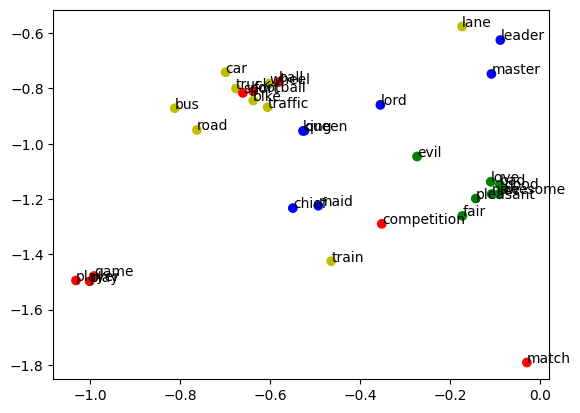

In [144]:
X_tsne = tsne.fit_transform(embeddings64[idx])
df = pd.DataFrame(X_tsne, index=target_vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'], c=color_codes)
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


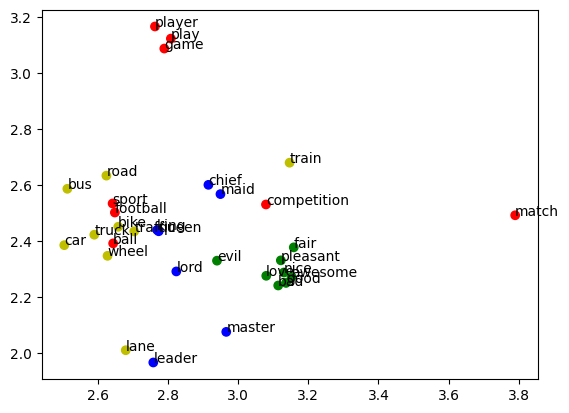

In [134]:
X_tsne = tsne.fit_transform(embeddings64[idx])
df = pd.DataFrame(X_tsne, index=target_vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'], c=color_codes)
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


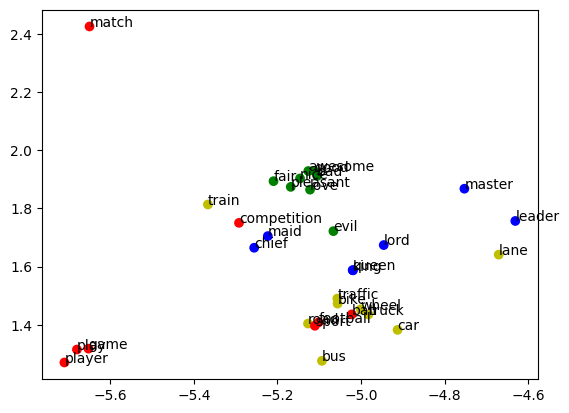

In [135]:
X_tsne = tsne.fit_transform(embeddings128[idx])
df = pd.DataFrame(X_tsne, index=target_vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'], c=color_codes)
for word, pos in df.iterrows():
    ax.annotate(word, pos)
plt.show()